Start

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy.engine import create_engine
from snowflake.sqlalchemy import URL
import dataframe_image as dfi  # To save styled DataFrame as image
from PIL import Image  # Handle images
from matplotlib.backends.backend_pdf import PdfPages  # Save multiple plots in a single PDF
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns


DB Connection

In [4]:
sf_engine = create_engine(URL(
  account='rt27428',
  region='eu-central-1',
  user='giannis.mermeklis@transferwise.com',
  authenticator='EXTERNALBROWSER',
  database='ANALYTICS_DB',
  warehouse='ANALYSTS'
))

In [11]:
top_3_pct_customers = """     
WITH top_3_pct_customers AS (
    SELECT USER_PROFILE_ID
    FROM (
        SELECT USER_PROFILE_ID,
               SUM(TOTAL_VOLUME_GBP) AS cross_volume_gbp,
               ROW_NUMBER() OVER (ORDER BY SUM(TOTAL_VOLUME_GBP) DESC) AS rank,
               COUNT(*) OVER () AS total_customers
        FROM ANALYTICS_DB.FIN_RPT_FINANCE.INT_FPA_GROWTH_TRANSACTIONS
        WHERE TRANSACTION_CREATED_DATE >= '2024-04-01' AND TRANSACTION_CREATED_DATE <= '2024-05-11' AND CURRENCY_TYPE = 'Cross'
        GROUP BY USER_PROFILE_ID
        QUALIFY rank <= CEIL(total_customers * 0.03)
    ) AS Ranked
)
SELECT TRANSACTION_CREATED_DATE,
       CUSTOMER_TYPE,
       USER_PROFILE_ID,
       SUM(TOTAL_VOLUME_GBP) AS cross_volume_gbp,
FROM ANALYTICS_DB.FIN_RPT_FINANCE.INT_FPA_GROWTH_TRANSACTIONS
WHERE USER_PROFILE_ID IN (SELECT USER_PROFILE_ID FROM top_3_pct_customers)
  AND TRANSACTION_CREATED_DATE >= '2024-04-01' AND TRANSACTION_CREATED_DATE <= '2024-05-11' AND CURRENCY_TYPE = 'Cross'
GROUP BY TRANSACTION_CREATED_DATE, CUSTOMER_TYPE, USER_PROFILE_ID
ORDER BY TRANSACTION_CREATED_DATE, USER_PROFILE_ID;
"""

In [13]:
# Load data and convert date field to datetime
top_3_pct_customers_df = pd.read_sql(top_3_pct_customers, sf_engine)
top_3_pct_customers_df['transaction_created_date'] = pd.to_datetime(top_3_pct_customers_df['transaction_created_date'])
top_3_pct_customers_df.head()

,transaction_created_date,customer_type,user_profile_id,cross_volume_gbp
0,2024-04-01,PERSONAL,385,721.9636
1,2024-04-01,PERSONAL,932,177.2818
2,2024-04-01,PERSONAL,1500,80.4400
3,2024-04-01,PERSONAL,1862,1717.8400
4,2024-04-01,BUSINESS,1990,3333.8997


In [15]:
top_3_pct_customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115346 entries, 0 to 1115345
Data columns (total 4 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   transaction_created_date  1115346 non-null  datetime64[ns]
 1   customer_type             1115346 non-null  object        
 2   user_profile_id           1115346 non-null  int64         
 3   cross_volume_gbp          1115346 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 34.0+ MB


In [17]:
# Group By Date
group_by_date_df = top_3_pct_customers_df.groupby(['transaction_created_date'])['cross_volume_gbp'].sum()
# Convert series to dataframe
group_by_date_df = group_by_date_df.reset_index()
group_by_date_df.rename(columns={'cross_volume_gbp': 'cross_volume_millions_gbp'}, inplace=True)
# Express volume in millions
group_by_date_df['cross_volume_millions_gbp'] = group_by_date_df['cross_volume_millions_gbp'] / 1_000_000
group_by_date_df.head()

,transaction_created_date,cross_volume_millions_gbp
0,2024-04-01,165.202945
1,2024-04-02,353.390336
2,2024-04-03,262.052182
3,2024-04-04,250.098811
4,2024-04-05,254.952934


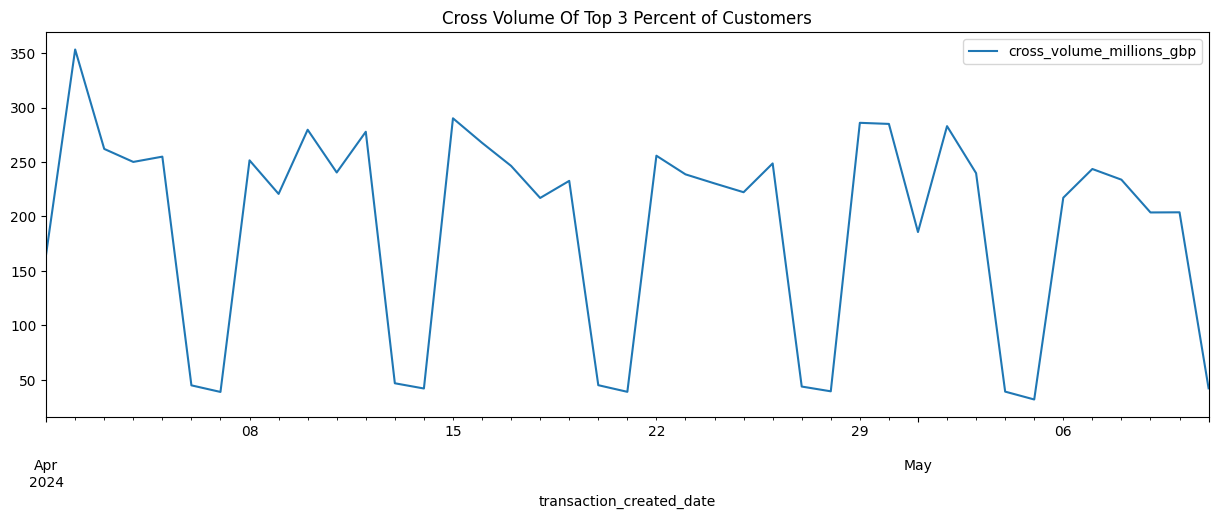

In [19]:
group_by_date_df.plot(x='transaction_created_date', y= 'cross_volume_millions_gbp', figsize=(15,5), legend = True)
plt.title('Cross Volume Of Top 3 Percent of Customers')
print()

In [21]:
# Group By Date and Customer Type
group_by_date_and_ct_df = top_3_pct_customers_df.groupby(['transaction_created_date','customer_type'])['cross_volume_gbp'].sum()
# Convert series to dataframe
group_by_date_and_ct_df = group_by_date_and_ct_df.reset_index()
group_by_date_and_ct_df.rename(columns={'cross_volume_gbp': 'cross_volume_millions_gbp'}, inplace=True)
# Express volume in millions
group_by_date_and_ct_df['cross_volume_millions_gbp'] = group_by_date_and_ct_df['cross_volume_millions_gbp'] / 1_000_000
group_by_date_and_ct_df.head()

,transaction_created_date,customer_type,cross_volume_millions_gbp
0,2024-04-01,BUSINESS,70.506816
1,2024-04-01,PERSONAL,94.696128
2,2024-04-02,BUSINESS,150.153411
3,2024-04-02,PERSONAL,203.236925
4,2024-04-03,BUSINESS,112.292338


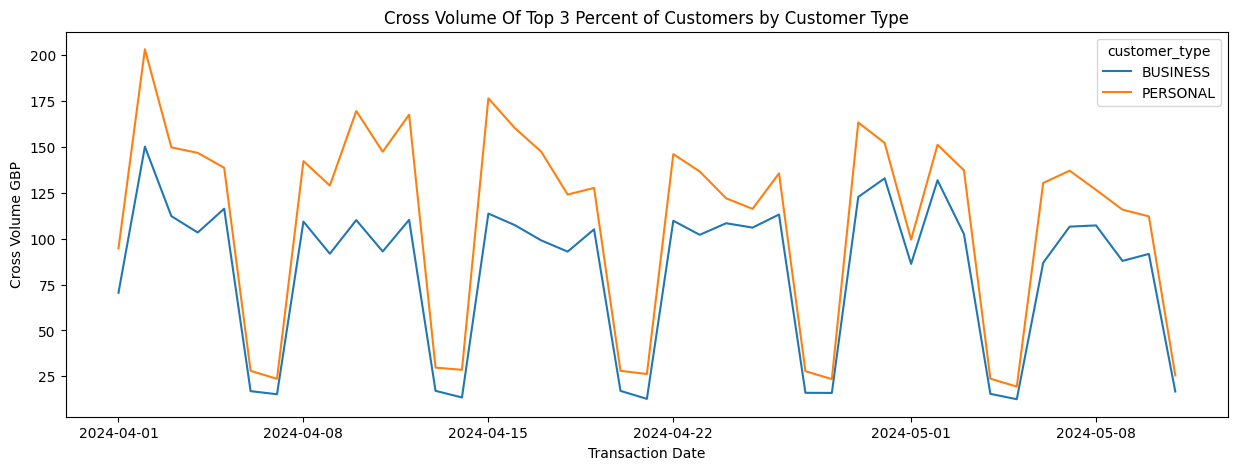

In [23]:
plt.figure(figsize=(15,5))
plt.xlabel('Transaction Date')
plt.ylabel('Cross Volume GBP')
sns.lineplot(group_by_date_and_ct_df, x = 'transaction_created_date', 
y ='cross_volume_millions_gbp', estimator= 'sum', hue = 'customer_type' )
plt.title('Cross Volume Of Top 3 Percent of Customers by Customer Type')
print()

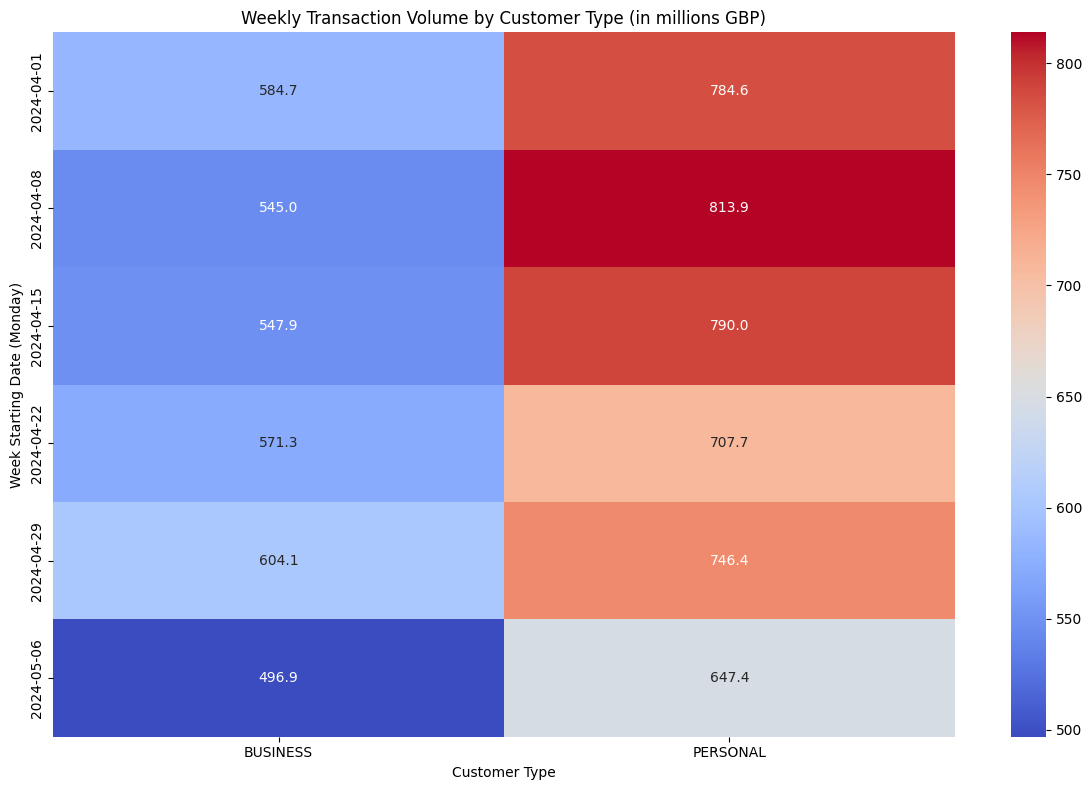

In [25]:
# Calculate the Monday date for each transaction date (first day of the week)
group_by_date_and_ct_df['week_start_date'] = group_by_date_and_ct_df['transaction_created_date'] - pd.to_timedelta(group_by_date_and_ct_df['transaction_created_date'].dt.dayofweek, unit='d')
# Group by week_start_date and customer_type, then sum the volume
weekly_volume = group_by_date_and_ct_df.groupby(['week_start_date', 'customer_type'])['cross_volume_millions_gbp'].sum().reset_index()
# Pivot the data to create a matrix suitable for a heatmap
pivot_data = weekly_volume.pivot(index='week_start_date', columns='customer_type', values='cross_volume_millions_gbp')
pivot_data.index = pivot_data.index.strftime('%Y-%m-%d')
# Create the heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Weekly Transaction Volume by Customer Type (in millions GBP)')
plt.ylabel('Week Starting Date (Monday)')
plt.xlabel('Customer Type')
plt.tight_layout()
plt.show()
